In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
k = 2
m = 30
n = 5000

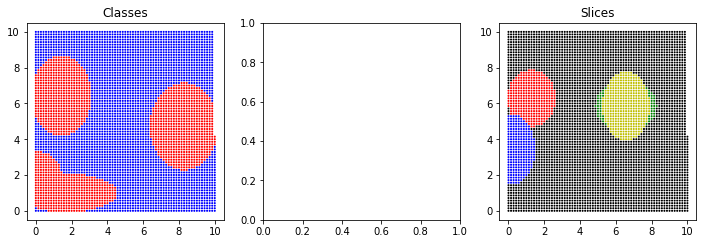

In [3]:
L, X, Y, Z = generate_dataset(k, m, n)

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.022,0.022,0.018,5,6,0.454545
1,"[1, 2]",0.280,0.280,0.246,108,32,0.771429
2,"[1, 2]",0.250,0.250,0.216,93,32,0.744000
3,"[1, 2]",0.210,0.210,0.176,71,34,0.676190
4,"[1, 2]",0.068,0.068,0.058,17,17,0.500000
5,"[1, 2]",0.048,0.048,0.042,17,7,0.708333
6,"[1, 2]",0.038,0.038,0.038,14,5,0.736842
7,"[1, 2]",0.260,0.260,0.240,101,29,0.776923
8,"[1, 2]",0.380,0.380,0.336,141,49,0.742105
9,"[1, 2]",0.144,0.142,0.112,50,22,0.694444


In [7]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [8]:
# np.save('synthetic_data.npy', (L, Y))

# Learn

In [9]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [10]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Inferred cardinality: 2


In [11]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.794

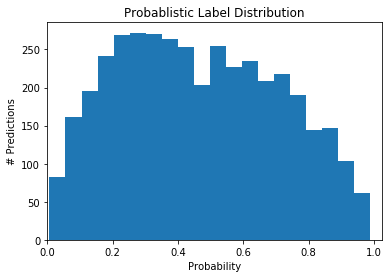

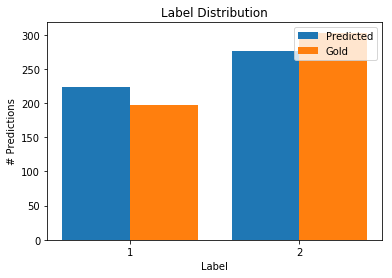

In [12]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

### EndModel

In [13]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [14]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.594
[E:0]	Train Loss: 0.732	Dev accuracy: 0.594
Saving model at iteration 1 with best score 0.638
Saving model at iteration 2 with best score 0.660
Saving model at iteration 3 with best score 0.700
Saving model at iteration 4 with best score 0.710
Saving model at iteration 5 with best score 0.712
[E:5]	Train Loss: 0.676	Dev accuracy: 0.712
Saving model at iteration 6 with best score 0.720
Saving model at iteration 7 with best score 0.782
Saving model at iteration 8 with best score 0.808
Saving model at iteration 9 with best score 0.810
Saving model at iteration 10 with best score 0.832
[E:10]	Train Loss: 0.664	Dev accuracy: 0.832


0.872

### SliceModel

In [15]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

In [16]:
import torch.nn as nn
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

n, m = Ls[0].shape
input_dim = Xs[0].shape[1]

input_module = MLPModule(input_dim, 10, [10], bias=True)
slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
                           verbose=False)
slice_model.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/Users/bradenjh/repos/metal/metal/contrib/slicing/online_dp.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward_Y(x)).data.cpu().numpy()


Saving model at iteration 0 with best score 0.690
[E:0]	Train Loss: 160.412	Dev accuracy: 0.690
Saving model at iteration 2 with best score 0.732
Saving model at iteration 4 with best score 0.742
Saving model at iteration 5 with best score 0.756
[E:5]	Train Loss: 152.060	Dev accuracy: 0.756
Saving model at iteration 6 with best score 0.772
[E:10]	Train Loss: 151.208	Dev accuracy: 0.760
Saving model at iteration 15 with best score 0.774
[E:15]	Train Loss: 150.588	Dev accuracy: 0.774
Saving model at iteration 18 with best score 0.782
Saving model at iteration 19 with best score 0.784
Saving model at iteration 20 with best score 0.786
[E:20]	Train Loss: 150.084	Dev accuracy: 0.786
Saving model at iteration 22 with best score 0.800
Saving model at iteration 24 with best score 0.804
Saving model at iteration 25 with best score 0.808
[E:25]	Train Loss: 149.453	Dev accuracy: 0.808
Saving model at iteration 26 with best score 0.818
[E:30]	Train Loss: 149.276	Dev accuracy: 0.812
Saving model at

### New SliceModel

In [17]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=30, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

Saving model at iteration 0 with best score 0.730
[E:0]	Train Loss: 0.626	Dev accuracy: 0.730


/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saving model at iteration 1 with best score 0.816
[E:5]	Train Loss: 0.607	Dev accuracy: 0.804
Saving model at iteration 7 with best score 0.838
Saving model at iteration 9 with best score 0.850
[E:10]	Train Loss: 0.602	Dev accuracy: 0.842
Saving model at iteration 12 with best score 0.894
Saving model at iteration 15 with best score 0.896
[E:15]	Train Loss: 0.597	Dev accuracy: 0.896
Saving model at iteration 16 with best score 0.912
[E:20]	Train Loss: 0.596	Dev accuracy: 0.904
Saving model at iteration 23 with best score 0.918
[E:25]	Train Loss: 0.593	Dev accuracy: 0.896
Saving model at iteration 26 with best score 0.920
[E:30]	Train Loss: 0.592	Dev accuracy: 0.880
Saving model at iteration 33 with best score 0.926
[E:35]	Train Loss: 0.591	Dev accuracy: 0.910
[E:40]	Train Loss: 0.592	Dev accuracy: 0.910
[E:45]	Train Loss: 0.591	Dev accuracy: 0.910
[E:49]	Train Loss: 0.590	Dev accuracy: 0.906
Restoring best model from iteration 33 with score 0.926
Finished Training
Accuracy: 0.926
     

In [18]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

100%|██████████| 500/500 [00:00<00:00, 22700.38it/s]


SUMMARY (accuracies):
All: 0.872
Slice 0: 0.9020618556701031
Slice 1: 0.9361702127659575
Slice 2: 0.5238095238095238
Slice 3: 0.5555555555555556
Slice 4: 0.7428571428571429



/Users/bradenjh/repos/metal/metal/contrib/slicing/online_dp.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward_Y(x)).data.cpu().numpy()
  0%|          | 0/500 [00:00<?, ?it/s]


SUMMARY (accuracies):
All: 0.826
Slice 0: 0.8350515463917526
Slice 1: 1.0
Slice 2: 0.5238095238095238
Slice 3: 0.5555555555555556
Slice 4: 0.7428571428571429


100%|██████████| 500/500 [00:00<00:00, 20653.25it/s]
/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



SUMMARY (accuracies):
All: 0.926
Slice 0: 0.9381443298969072
Slice 1: 0.9787234042553191
Slice 2: 0.5238095238095238
Slice 3: 1.0
Slice 4: 0.9428571428571428


In [19]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [20]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

### Repeated Trials

In [21]:
# Grid search as necessary first


Inferred cardinality: 2

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.394
[E:0]	Train Loss: 0.694	Dev accuracy: 0.394
Saving model at iteration 1 with best score 0.606
[E:5]	Train Loss: 0.693	Dev accuracy: 0.394
[E:10]	Train Loss: 0.693	Dev accuracy: 0.606
[E:15]	Train Loss: 0.693	Dev accuracy: 0.606
[E:20]	Train Loss: 0.693	Dev accuracy: 0.606
[E:25]	Train Loss: 0.693	Dev accuracy: 0.606
[E:30]	Train Loss: 0.693	Dev accuracy: 0.606
[E:35]	Train Loss: 0.692	Dev accuracy: 0.606
[E:40]	Train Loss: 0.692	Dev accuracy: 0.606
[E:45]	Train Loss: 0.692	Dev accuracy: 0.606


100%|██████████| 500/500 [00:00<00:00, 27745.61it/s]

[E:49]	Train Loss: 0.692	Dev accuracy: 0.606
Restoring best model from iteration 1 with score 0.606
Finished Training
Accuracy: 0.606
        y=1    y=2   
 l=1     0      0    
 l=2    197    303   



SUMMARY (accuracies):
All: 0.624
Slice 0: 0.6263157894736842
Slice 1: 0.7777777777777778
Slice 2: 1.0
Slice 3: 0.0
Slice 4: 0.5384615384615384

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=30, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)



/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saving model at iteration 0 with best score 0.752
[E:0]	Train Loss: 0.628	Dev accuracy: 0.752
Saving model at iteration 3 with best score 0.760
[E:5]	Train Loss: 0.615	Dev accuracy: 0.700
Saving model at iteration 9 with best score 0.772
[E:10]	Train Loss: 0.613	Dev accuracy: 0.754
[E:15]	Train Loss: 0.613	Dev accuracy: 0.764
Saving model at iteration 17 with best score 0.780
[E:20]	Train Loss: 0.612	Dev accuracy: 0.748
[E:25]	Train Loss: 0.611	Dev accuracy: 0.778
[E:30]	Train Loss: 0.611	Dev accuracy: 0.764
[E:35]	Train Loss: 0.610	Dev accuracy: 0.766
[E:40]	Train Loss: 0.610	Dev accuracy: 0.764
[E:45]	Train Loss: 0.609	Dev accuracy: 0.766


100%|██████████| 500/500 [00:00<00:00, 23205.00it/s]

[E:49]	Train Loss: 0.609	Dev accuracy: 0.768
Restoring best model from iteration 17 with score 0.780
Finished Training
Accuracy: 0.780
        y=1    y=2   
 l=1    174    87    
 l=2    23     216   



SUMMARY (accuracies):
All: 0.786
Slice 0: 0.7578947368421053
Slice 1: 0.2222222222222222
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 0.9743589743589743
Inferred cardinality: 2

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.874
[E:0]	Train Loss: 0.652	Dev accuracy: 0.874
Saving model at iteration 1 with best score 0.950
Saving model at iteration 2 with best score 0.974
[E:5]	Train Loss: 0.641	Dev accuracy: 0.946
[E:10]	Train Loss: 0.638	Dev accuracy: 0.922
[E:15]	Train Loss: 0.636	Dev accuracy: 0.938
[E:20]	Train Loss: 0.637	Dev accuracy: 0.934
[E:25]	Train Loss: 0.634	Dev accuracy: 0.944
[E:30]	Train Loss: 0.633	Dev accuracy: 0.954
[E:35]	Train Loss: 0.633	Dev accuracy: 0.930
[E:40]	T

100%|██████████| 500/500 [00:00<00:00, 25783.81it/s]

[E:49]	Train Loss: 0.632	Dev accuracy: 0.948
Restoring best model from iteration 2 with score 0.974
Finished Training
Accuracy: 0.974
        y=1    y=2   
 l=1    98      4    
 l=2     9     389   



SUMMARY (accuracies):
All: 0.968
Slice 0: 0.9675810473815462
Slice 1: 0.8695652173913043
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=30, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

Saving model at iteration 0 with best 

100%|██████████| 500/500 [00:00<00:00, 25975.10it/s]

[E:49]	Train Loss: 0.571	Dev accuracy: 0.970
Restoring best model from iteration 1 with score 0.976
Finished Training
Accuracy: 0.976
        y=1    y=2   
 l=1    104     9    
 l=2     3     384   



SUMMARY (accuracies):
All: 0.972
Slice 0: 0.972568578553616
Slice 1: 0.8695652173913043
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0
Inferred cardinality: 2

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.832
[E:0]	Train Loss: 0.659	Dev accuracy: 0.832
Saving model at iteration 1 with best score 0.872
Saving model at iteration 2 with best score 0.890
Saving model at iteration 3 with best score 0.916
[E:5]	Train Loss: 0.645	Dev accuracy: 0.858
Saving model at iteration 8 with best score 0.926
[E:10]	Train Loss: 0.646	Dev accuracy: 0.880
Saving model at iteration 13 with best score 0.932
Saving model at iteration 15 with best score 0.934
[E:15]	Train Loss: 0.641	Dev accuracy: 0.934
[E

100%|██████████| 500/500 [00:00<00:00, 29053.27it/s]

[E:49]	Train Loss: 0.636	Dev accuracy: 0.920
Restoring best model from iteration 15 with score 0.934
Finished Training
Accuracy: 0.934
        y=1    y=2   
 l=1    140    21    
 l=2    12     327   



SUMMARY (accuracies):
All: 0.944
Slice 0: 0.9719101123595506
Slice 1: 1.0
Slice 2: 0.8870967741935484
Slice 3: 0.6470588235294118
Slice 4: 0.84375

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=30, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

Saving model at ite

100%|██████████| 500/500 [00:00<00:00, 27367.25it/s]

[E:49]	Train Loss: 0.597	Dev accuracy: 0.844
Restoring best model from iteration 45 with score 0.864
Finished Training
Accuracy: 0.864
        y=1    y=2   
 l=1    98     14    
 l=2    54     334   



SUMMARY (accuracies):
All: 0.88
Slice 0: 0.9241573033707865
Slice 1: 0.9696969696969697
Slice 2: 0.8548387096774194
Slice 3: 0.35294117647058826
Slice 4: 0.625
{'overall': [0.624, 0.968, 0.944], 'slices': [0.7777777777777778, 1.0, 0.0, 0.5384615384615384, 0.8695652173913043, 1.0, 1.0, 1.0, 1.0, 0.8870967741935484, 0.6470588235294118, 0.84375]}
{'overall': [0.786, 0.972, 0.88], 'slices': [0.2222222222222222, 1.0, 1.0, 0.9743589743589743, 0.8695652173913043, 1.0, 1.0, 1.0, 0.9696969696969697, 0.8548387096774194, 0.35294117647058826, 0.625]}


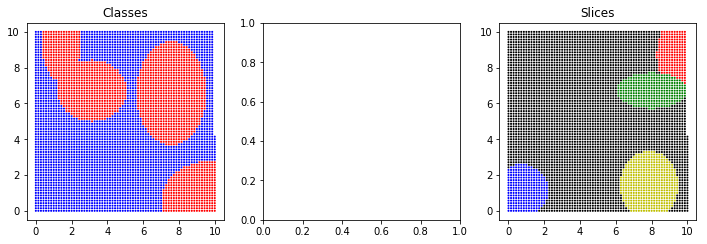

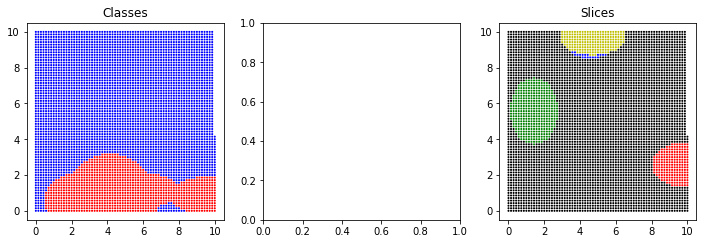

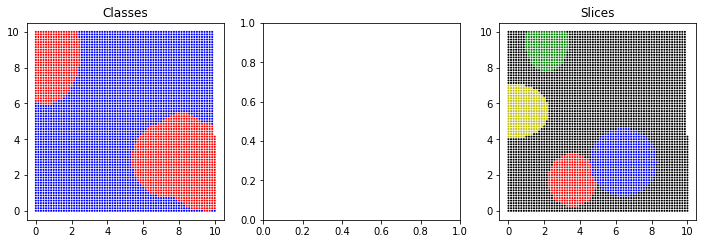

In [22]:
from metal.utils import split_data, SlicingDataset
from metal.label_model.baselines import MajorityLabelVoter
from metal.end_model import EndModel
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.synthetics.geometric_synthetics import *
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.slicing.utils import evaluate_slicing

import torch
from torch.utils.data import DataLoader

NUM_TRIALS = 3
SPLIT = 2

k = 2
m = 30
n = 5000

batchsize = 32
layer_output_dims = [2, 10, 10, 2]
slice_weight = 0.1

summary = {}
for model in ['mv', 'dp', 'up', 'me', 'sm']:
    summary[model] = {
        'overall': [],
        'slices': []
    }

for i in range(NUM_TRIALS):
    L, X, Y, Z = generate_dataset(k, m, n, plotting=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
    lm = SnorkelLabelModel()
    lm.train_model(Ls[0])
    Y_train_ps = lm.predict_proba(Ls[0])

    dev_loader = DataLoader(
        SlicingDataset(Xs[1], Ys[1]),
        batch_size=256,
    )
    eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))
    
    # Train dp
    em_train_loader = DataLoader(
        SlicingDataset(Xs[0], Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )    
    
    dp = EndModel(layer_output_dims)
    dp.train_model(
        em_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )

    dp_results = evaluate_slicing(dp, eval_loader, verbose=False)
    summary['dp']['overall'].append(dp_results['all']['accuracy'])
    for s in range(1,5):
        summary['dp']['slices'].append(dp_results[f'slice_{s}']['accuracy'])    
    
    # Train dp_sm
    L_train = torch.Tensor(np.asarray(Ls[0].todense()))    
    sm_train_loader = DataLoader(
        SlicingDataset(Xs[0], L_train, Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )
    
    dp = EndModel(layer_output_dims) # Fresh copy to be safe
    sm = SliceHatModel(dp, m, slice_weight=slice_weight)
    sm.train_model(
        sm_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )
    
    sm_results = evaluate_slicing(sm, eval_loader, verbose=False)
    summary['sm']['overall'].append(sm_results['all']['accuracy'])
    for s in range(1,5):
        summary['sm']['slices'].append(sm_results[f'slice_{s}']['accuracy'])

print(summary['dp'])
print(summary['sm'])

In [23]:
for key in ['dp', 'sm']:
    mean_overall = np.mean(summary[key]['overall'])
    slices_overall = np.mean(summary[key]['slices'])
    print(f"{key}: {mean_overall:.3f}, {slices_overall:.3f}")
# print(summary['dp'])
# print(summary['sm'])

dp: 0.845, 0.797
sm: 0.879, 0.822


In [24]:
#     lm_train_loader = DataLoader(SlicingDataset(Ls[0], Ys[0], Zs[0]), batch_size=batchsize)
#     lm_dev_loader = DataLoader(SlicingDataset(Ls[1], Ys[1], Zs[1]), batch_size=batchsize)
#     lm_test_loader = DataLoader(SlicingDataset(Ls[2], Ys[2], Zs[2]), batch_size=batchsize)

#     em_train_loader = DataLoader(SlicingDataset(Xs[0], Ys[0], Zs[0]), batch_size=batchsize)
#     em_dev_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]), batch_size=batchsize)
#     em_test_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]), batch_size=batchsize)
    
#     majority_voter = MajorityLabelVoter()
#     Y_train_ps = majority_voter.predict_proba(Ls[SPLIT])
#     mv_em = EndModel(layer_output_dims)
#     mv_em.train_model(em_train_loader, em_)
#     summary['mv']
    
#     label_model = SnorkelLabelModel()
#     label_model.train_model(Ls[0])
#     lm_results = evaluate_slicing(label_model, lm_eval_loader, verbose=False, break_ties=2)
